# Image Segmentation from pre-trained Detectron2 model

The purpose of the present analysis is to perform Image Segmentation recognizing surfaces. [OpenSurfaces](http://opensurfaces.cs.cornell.edu/) is a great dataset with high quantity of images with surfaces annotations and it was used for this task.

I have chosen the detection framework Detectron2 per its simplicity to build object detection models. I will use a model pre-trained on the COCO dataset. COCO has fewer object categories than others famous datasets such as ImageNet, but more instances per category. As future task I would use the ImageNet dataset and find which one would be the most suitable for our data.



In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage import io, measure
from shutil import copyfile
import sys
from PIL import Image
from shapely.geometry import Polygon, MultiPolygon 

from detectron2.structures import BoxMode
from detectron2.utils.logger import setup_logger
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo

### Data
OpenSurfaces contains around 25k images plus their masks, all information well documented. 

Around 3442 images have no segmentation, i.e. black images. So I just will remove from my dataset those photos from which it is not possible to extract information. 

In [ ]:
def detect_black_images(path):
    black_imgs = []
    for photo in os.listdir(path):
        image = cv2.imread(path+photo, 0)
        if cv2.countNonZero(image) == 0:
            black_imgs.append(photo)
    return black_imgs

#remove black images from data folder
for photo in list_black:
    os.remove('../photos-labels/' + photo)

photos_to_remove = [x[:-4] for x in list_black]
for photo in photos_to_remove:
    os.remove('../photos/' + photo + '.jpg')

Let's look at the annotations for each photo.

In [2]:
photos = pd.read_csv('../photos.csv')
photos.head()

,photo_id,scene_category_name,scene_category_score,whitebalanced,whitebalanced_score,fov,flickr_url,license_name,license_is_creative_commons
0,105314,bedroom,0.245367,True,1.128978,44.158275,http://www.flickr.com/photos/yeowatzup/1558411...,Attribution 2.0 Generic,True
1,99622,bedroom,0.420035,False,-0.025998,63.321502,http://www.flickr.com/photos/ballyhoura/385314...,Attribution-ShareAlike 2.0 Generic,True
2,105479,bedroom,1.002425,True,0.982525,52.813552,http://www.flickr.com/photos/jared422/7857205982/,Attribution 2.0 Generic,True
3,109010,hallway,0.220542,False,-0.047303,73.249305,http://www.flickr.com/photos/jiuguangw/5149041...,Attribution-ShareAlike 2.0 Generic,True
4,92343,dining room,0.112771,True,0.973520,52.813552,http://www.flickr.com/photos/jared422/7825091776/,Attribution 2.0 Generic,True


In [3]:
shapes = pd.read_csv('../shapes.csv')
shapes.head()

,shape_id,photo_id,substance_name,name_name,albedo_r,albedo_g,albedo_b,albedo_score,gloss_c,gloss_d,gloss_score,planar,planar_score,normal_matrix,normal_score
0,170565,99622,Wood,Bed/bed frame,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,-0.880611,NaN,NaN
1,143585,105479,Wood,Bed/bed frame,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,-1.140647,NaN,NaN
2,158420,105314,Fur,Stuffed animal/plush toy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,-0.974276,NaN,NaN
3,130080,97315,Metal,NaN,2.157510e-10,1.659623e-10,1.659623e-10,0.280833,0.000,0.799000,0.394607,False,-1.145028,NaN,NaN
4,169391,98653,Wood,Bed/bed frame,1.143630e-09,4.709066e-10,2.859076e-10,0.366268,0.044,0.812333,0.351267,False,-0.330448,NaN,NaN


Each photo has several features that for sure would be helpful to build the model, but in order to keep it as simple as possible I will just use the main characteristics.

I will collect the information in one dataframe to make the annotations for my dataset.

In [4]:
#Merging all the tables in one
df = photos[['photo_id','scene_category_name']]
df1 = shapes[['shape_id', 'photo_id', 'substance_name', 'name_name']]
df = df.merge(df1, how='left', left_on='photo_id', right_on='photo_id')

lab1 = pd.read_csv('../label-substance-colors.csv')
df = df.merge(lab1, how='left', left_on='substance_name', right_on='substance_name')
lab2 = pd.read_csv('../label-name-colors.csv')
df = df.merge(lab2, how='left', left_on='name_name', right_on='name_name')

lab3 = pd.read_csv('../label-scene-colors.csv')
df = df.merge(lab3, how='left', left_on='scene_category_name', right_on='scene_category_name')

del photos, shapes, lab1, lab2, lab3

df.head()

,photo_id,scene_category_name,shape_id,substance_name,name_name,substance_id,red_color,name_id,green_color,scene_category_id,blue_color
0,105314,bedroom,158420.0,Fur,Stuffed animal/plush toy,24.0,13.0,167.0,173.0,6,3
1,105314,bedroom,158416.0,Fabric/cloth,NaN,29.0,9.0,NaN,NaN,6,3
2,105314,bedroom,158417.0,Painted,Wall,41.0,24.0,1.0,195.0,6,3
3,105314,bedroom,158413.0,Fabric/cloth,Pillow/cushion,29.0,9.0,70.0,133.0,6,3
4,105314,bedroom,158418.0,Fabric/cloth,Pillow/cushion,29.0,9.0,70.0,133.0,6,3


In [5]:
# filter main features and remove duplicates as well as NA values
subdf = df[['photo_id','shape_id','substance_name','name_name','red_color','green_color','blue_color']].drop_duplicates()
subdf = subdf.dropna(subset=['red_color', 'green_color', 'blue_color', 'shape_id'])

del df
print("Number of distinct surfaces: ", len(subdf.substance_name.unique()))

Number of distinct surfaces:  26


There are 26 classes available in the dataset, I think with the quantity of available data in the dataset and maybe performing augmentation it is faisable to train the model to detect all those classes. Unfortunately I don't have enough computational power for such task, instead I will reduce the segmentation to just three general categories: floor, wall and table.

In [6]:
subdf = subdf[subdf.name_name.isin(['Floor','Wall','Table'])]
category_id = [x for x in range(0,3)] # only three classes
new_df = pd.DataFrame({'category_id': category_id, 'name_name': ['Floor','Wall','Table']})
subdf = subdf.merge(new_df, how='left', left_on='name_name', right_on='name_name')

del category_id, new_df
subdf.head()

,photo_id,shape_id,substance_name,name_name,red_color,green_color,blue_color,category_id
0,105314,158417.0,Painted,Wall,24.0,195.0,3,1
1,98653,169390.0,Wood,Floor,43.0,83.0,3,0
2,107359,160743.0,Tile,Floor,36.0,83.0,8,0
3,107359,160742.0,Tile,Wall,36.0,195.0,8,1
4,118061,163898.0,Linoleum,Floor,20.0,83.0,15,0


I will only select the images that contain at least one of these classes. From the original dataset, 11411 photos include them.

In [42]:
# Make a subset from the dataset that contains the classes that will be use to train the dataset
import shutil
files = [x for x in subdf.photo_id.unique()]
for f in files:
    shutil.move("../photos/"+str(f)+".jpg", '../photos/train')
len(files)

11411

### Model

Let's run the pre-trained and pre-labeled model to check that everything is working properly. As suggested by the Detectron2 documentation I will load the popular algorithm for instance segmentation, Mask R-CNN with Feature Pyramid Network (FPN), which gives excellent accuracy and it is pretty fast.

In [7]:
setup_logger()
cfg = get_cfg()
cfg.MODEL.DEVICE='cpu'

In [15]:
im = cv2.imread("../photos/232.jpg")
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

/Users/lina/DataScience/image_segmentation/scripts/detectron2/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


tensor([56, 73, 73, 73, 73, 73, 57, 73, 73, 69, 74, 73, 73, 73, 73])
Boxes(tensor([[1.2943e+03, 2.0115e+03, 2.4412e+03, 3.2471e+03],
        [1.7772e+03, 5.9356e+02, 1.8648e+03, 9.4889e+02],
        [2.0392e+03, 5.4448e+02, 2.1307e+03, 9.4344e+02],
        [1.8535e+03, 5.7876e+02, 1.9252e+03, 9.3893e+02],
        [1.9128e+03, 5.7015e+02, 1.9871e+03, 9.4683e+02],
        [1.9731e+03, 5.5629e+02, 2.0579e+03, 9.4651e+02],
        [0.0000e+00, 2.0337e+03, 1.1917e+03, 3.2341e+03],
        [1.9494e+03, 5.4802e+02, 2.1160e+03, 9.4883e+02],
        [2.1569e+03, 5.9176e+02, 2.2651e+03, 9.5580e+02],
        [0.0000e+00, 4.5549e+02, 3.2956e+02, 1.5356e+03],
        [2.6892e+00, 4.9869e+02, 1.2334e+02, 6.4820e+02],
        [8.8691e+02, 5.9796e+02, 1.4075e+03, 6.7622e+02],
        [1.7915e+03, 5.4580e+02, 2.1570e+03, 9.5302e+02],
        [2.1083e+03, 5.4457e+02, 2.1823e+03, 9.5409e+02],
        [1.8751e+03, 5.4980e+02, 2.0278e+03, 9.4982e+02]]))


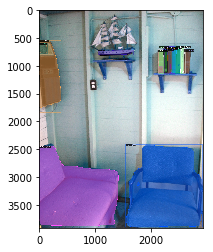

In [146]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

#Last and final step is to visualize our processed image.
v = Visualizer(imx[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

The model works perfectly but it does not include categories like floor or wall. Then I will proceed to train the model and hopefully it will be able to segment the image on these classes.

First at all, it is necessary to let detectron2 know how to obtain the custom data and make the proper annotations to register our dataset. 

The next function is built to detect the segmentations of the photos labels.

In [8]:
#function to detect color pixels of the mask
def create_sub_masks(mask_image):
    width, height = mask_image.size
    print('masksize: ', width,height)

    # Initialize a dictionary of sub-masks indexed by RGB colors
    sub_masks = {}
    for x in range(width):
        for y in range(height):
            # Get the RGB values of the pixel
            pixel = mask_image.getpixel((x,y))[:3]

            # If the pixel is not black...
            if pixel != (0, 0, 0):
                # Check to see if we've created a sub-mask...
                pixel_str = str(pixel)
                sub_mask = sub_masks.get(pixel_str)
                if sub_mask is None:
                   # Create a sub-mask (one bit per pixel) and add to the dictionary
                    # Note: we add 1 pixel of padding in each direction
                    # because the contours module doesn't handle cases
                    # where pixels bleed to the edge of the image
                    sub_masks[pixel_str] = Image.new('1', (width+2, height+2))

                # Set the pixel value to 1 (default is 0), accounting for padding
                sub_masks[pixel_str].putpixel((x+1, y+1), 1)

    return sub_masks

In [22]:
print(create_sub_masks(Image.open('../photos-labels/66062.png')).items())

masksize:  676 1024
dict_items([('(0, 0, 15)', <PIL.Image.Image image mode=1 size=678x1026 at 0x1C643E70F0>), ('(43, 34, 15)', <PIL.Image.Image image mode=1 size=678x1026 at 0x1C643E7128>), ('(12, 107, 15)', <PIL.Image.Image image mode=1 size=678x1026 at 0x1C4EEDAB00>), ('(22, 92, 15)', <PIL.Image.Image image mode=1 size=678x1026 at 0x1C643E7208>)])


After the segments of each image are found, the next function will build and give the coordinates of the bounding boxes.

In [9]:
# Find contours (boundary lines) around each sub-mask
def create_sub_mask_annotation(sub_mask, image_id, category_id, annotation_id, is_crowd):

    contours = measure.find_contours(sub_mask, 0.5, positive_orientation='low')

    segmentations = []
    polygons = []
    for contour in contours:
        # Flip from (row, col) representation to (x, y)
        # and subtract the padding pixel
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # Make a polygon and simplify it
        poly = Polygon(contour)
        #print('poly ', poly)
        poly = poly.simplify(0.2, preserve_topology=False)
        #print('simp: ', poly)
        polygons.append(poly)
        segmentation = np.array(poly.exterior.coords).ravel().tolist()
        #print('seg: ',segmentation)
        segmentations.append(segmentation)

    # Combine the polygons to calculate the bounding box and area
    multi_poly = MultiPolygon(polygons)
    x, y, max_x, max_y = multi_poly.bounds
    width = max_x - x
    height = max_y - y
    bbox = (x, y, width, height)
    area = multi_poly.area

    annotation = {
        'segmentation': segmentations,
        'iscrowd': is_crowd,
        'image_id': image_id,
        'category_id': int(category_id),
        'id': annotation_id,
        'bbox': bbox,
        'bbox_mode': BoxMode.XYWH_ABS,
        'area': area
    }

    return annotation

Finally, the next function will return a list with the corresponding image annotations. Exists some tools for annotate images efficiently, maybe these should be explorer in the future.

In [10]:
# get list with annotations for the images in the dataset.
def get_data_dicts(dir_img, df):
    #df refers to the dataframe cotaining the information of the images.
    
    img_ids = os.listdir(dir_img)
    img_ids = [x[:-4] for x in img_ids]
    print('N. images: ', len(img_ids))

    dataset_dicts = []
    for img_id in img_ids:
        
        mask_image = os.path.join('../photos-labels', '%s.png' % img_id)       
        org_image = os.path.join(dir_img, '%s.jpg' % img_id)

        if not (os.path.exists(mask_image) and os.path.exists(org_image)):
            continue
        
        mask_image = Image.open(mask_image)       
        
        record = {}
        
        height, width = cv2.imread(org_image).shape[:2]
        
        #resize mask image
        mask_image = mask_image.resize((width,height))
        
        record["file_name"] = org_image
        record["image_id"] = img_id
        record["height"] = height
        record["width"] = width
      
        category_ids = {}
        shape_id = [x for x in df[df.photo_id==int(img_id)].category_id.tolist() if x==x]
        for subs in shape_id:
            red = df[(df.photo_id==int(img_id)) & (df.category_id==subs)].red_color.tolist()[0]
            green = df[(df.photo_id==int(img_id)) & (df.category_id==subs)].green_color.tolist()[0]
            blue = df[(df.photo_id==int(img_id)) & (df.category_id==subs)].blue_color.tolist()[0]
            color_id = (int(red),int(green),int(blue))
            category_ids[str(color_id)] = subs

        is_crowd = 0
        annotation_id = 1

        annotations = []
        sub_masks = create_sub_masks(mask_image)
        
        for color, sub_mask in sub_masks.items():
            if color in category_ids.keys():
                category_id = category_ids[color]
                annotation = create_sub_mask_annotation(sub_mask, img_id, category_id, annotation_id, is_crowd)
                annotations.append(annotation)
                annotation_id += 1
        
        if not annotations:
            continue 
        
        record["annotations"] = annotations
        categories = []
        for id_cat in df.category_id.unique():
            labels = {}
            labels['supercategory'] = df.loc[df['category_id'] == id_cat, 'name_name'].unique()[0]
            labels['id'] = int(id_cat)
            categories.append(labels)
    
        record["categories"] = categories
        dataset_dicts.append(record)
    
    return dataset_dicts

In [56]:
print(get_data_dicts('../photos/val', subdf))

masksize:  3872 2592
[{'file_name': '../photos/val/105189.jpg', 'image_id': '105189', 'height': 2592, 'width': 3872, 'annotations': [{'segmentation': [[15.0, 203.5, 15.5, 203.0, 15.0, 202.5, 14.5, 203.0, 15.0, 203.5], [727.0, 2591.5, 727.5, 2591.0, 727.5, 2586.0, 728.0, 2585.5, 730.0, 2585.5, 730.5, 2585.0, 730.5, 2581.0, 731.0, 2580.5, 732.0, 2580.5, 732.5, 2580.0, 732.0, 2579.5, 731.0, 2579.5, 730.5, 2579.0, 731.0, 2578.5, 732.0, 2578.5, 732.5, 2578.0, 732.5, 2576.0, 733.0, 2575.5, 735.0, 2575.5, 735.5, 2575.0, 735.5, 2571.0, 736.0, 2570.5, 737.0, 2570.5, 737.5, 2570.0, 737.0, 2569.5, 736.0, 2569.5, 735.5, 2569.0, 736.0, 2568.5, 737.0, 2568.5, 737.5, 2568.0, 737.5, 2567.0, 739.0, 2565.5, 740.0, 2565.5, 740.5, 2565.0, 740.0, 2564.5, 739.0, 2564.5, 738.5, 2564.0, 739.0, 2563.5, 740.0, 2563.5, 740.5, 2563.0, 740.5, 2561.0, 741.0, 2560.5, 742.0, 2560.5, 742.5, 2560.0, 741.5, 2559.0, 742.5, 2558.0, 742.5, 2557.0, 743.5, 2556.0, 743.5, 2554.0, 744.0, 2553.5, 745.0, 2553.5, 745.5, 2553.0, 7

#### Trainning

Before training the model in our custome dataset, they have to be registered on the DatasetCatalog. 

Also, let's check if everything is working as intended, the images should have now bounding boxes in the floor and walls.

In [11]:
classes = [x for x in subdf.sort_values(by=['category_id']).name_name.unique()]

#DatasetCatalog.register("my_dataset", get_data_dicts(photos))
for d in ["train", "val"]:
    DatasetCatalog.register(d, lambda d=d: get_data_dicts("../photos/"+d, subdf))
    MetadataCatalog.get(d).set(thing_classes=classes)
mydata_metadata = MetadataCatalog.get("train")

N. images:  10
masksize:  3872 2592
masksize:  3246 2045
masksize:  2161 2878
masksize:  3648 2736
masksize:  3648 2736
masksize:  2448 3264
masksize:  3264 2448
masksize:  3968 2232
masksize:  3648 2736
masksize:  3648 2736


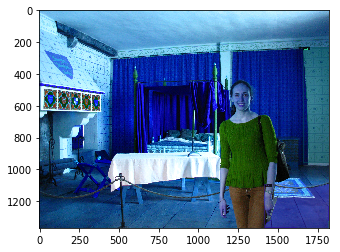

In [17]:
dataset_dicts = get_data_dicts("../photos/val", subdf)
for d in random.sample(dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=mydata_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    cv2.imwrite('test.png', out.get_image()[:, :, ::-1]) 

Now I will configure the model for trainning.  

In [12]:
cfg = get_cfg()
cfg.MODEL.DEVICE='cpu'
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.01#0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)  # only 3 classes ['Floor', 'Wall', 'Table']

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/06 18:36:13 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

N. images:  57
masksize:  3888 2592
masksize:  4000 3000
masksize:  3872 2592
masksize:  3072 2304
masksize:  2848 4272
masksize:  2848 4288
masksize:  3246 2045
masksize:  3200 4800
masksize:  3888 2592
masksize:  3181 2120
masksize:  4368 2912
masksize:  3216 2144
masksize:  2000 3008
masksize:  2736 3648
masksize:  3072 2304
masksize:  3888 2592
masksize:  4272 2848
masksize:  3008 2000
masksize:  3648 2736
masksize:  2736 3648
masksize:  3888 2592
masksize:  3351 2224
masksize:  2586 3892
masksize:  3039 2014
masksize:  3072 2304
masksize:  3648 2736
masksize:  2448 3264
masksize:  4752 3168
masksize:  2848 4272
masksize:  2448 3264
masksize:  3008 2000
masksize:  3648 2736
masksize:  3542 2494
masksize:  3216 2144
masksize:  3072 2048
masksize:  3072 2048
masksize:  3008 2000
masksize:  2304 3072
masksize:  3008 2000
masksize:  3008 2000
masksize:  4288 2848
masksize:  5184 3456
masksize:  3264 2448
masksize:  3968 2232
masksize:  3872 2592
masksize:  3072 2048
masksize:  3504 233

/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

[12/06 19:12:43 d2.engine.train_loop]: Starting training from iteration 0
[12/06 19:24:41 d2.utils.events]:  eta: 2:49:22  iter: 19  total_loss: 2.113  loss_cls: 1.125  loss_box_reg: 0.1486  loss_mask: 0.6916  loss_rpn_cls: 0.07951  loss_rpn_loc: 0.01537  time: 35.7887  data_time: 0.0495  lr: 0.00019981  
[12/06 19:36:29 d2.utils.events]:  eta: 2:37:16  iter: 39  total_loss: 1.368  loss_cls: 0.335  loss_box_reg: 0.2867  loss_mask: 0.6766  loss_rpn_cls: 0.05982  loss_rpn_loc: 0.01142  time: 35.5876  data_time: 0.0089  lr: 0.00039961  
[12/06 19:50:04 d2.utils.events]:  eta: 2:27:38  iter: 59  total_loss: 1.318  loss_cls: 0.3089  loss_box_reg: 0.2879  loss_mask: 0.6553  loss_rpn_cls: 0.0328  loss_rpn_loc: 0.01142  time: 37.3496  data_time: 0.0106  lr: 0.00059941  
[12/06 20:03:07 d2.utils.events]:  eta: 2:17:58  iter: 79  total_loss: 1.233  loss_cls: 0.301  loss_box_reg: 0.3612  loss_mask: 0.5312  loss_rpn_cls: 0.02841  loss_rpn_loc: 0.01293  time: 37.8175  data_time: 0.0109  lr: 0.00079

I found some issues while trainning:

- As running the model on CPU, the computational power is not enough to train large quantity of images, I had to reduce the trainning set to 57 images, which unfortunately would not lead to expected results.
- It took more than 3h to train 57 images, long time for such a small dataset.
- Due to these limitations I could not be able to tune the hyperparameters. I just tried to find an acceptable learning rate, the small loss was obtained with a value of 0.01.
- I trained only with 100 iterations, larger number will lead to better results.

Now, I will check how the model infers on the validation dataset.

In [44]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

Skip loading parameter 'proposal_generator.rpn_head.conv.weight' to the model due to incompatible shapes: (256, 256, 3, 3) in the checkpoint but (1024, 1024, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.conv.bias' to the model due to incompatible shapes: (256,) in the checkpoint but (1024,) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.objectness_logits.weight' to the model due to incompatible shapes: (3, 256, 1, 1) in the checkpoint but (15, 1024, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.objectness_logits.bias' to the model due to incompatible shapes: (3,) in the checkpoint but (15,) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.anchor_deltas.weight' to the model due to incompatible s

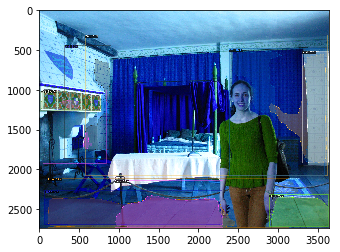

In [22]:
from pathlib import Path
validation_folder = Path("../photos/val")

for i, file in enumerate(validation_folder.glob("*.jpg")):
    # this loop opens the .jpg files from the val-folder, creates a dict with the file
    # information, plots visualizations and saves the result as .pkl files.
    file = str(file)
    file_name = file.split("/")[-1]
    im = cv2.imread(file)

    outputs = predictor(im)
    output_with_filename = {}
    output_with_filename["file_name"] = file_name
    output_with_filename["file_location"] = file
    output_with_filename["prediction"] = outputs
    # the following two lines save the results as pickle objects, you could also
    # name them according to the file_name if you want to keep better track of your data
    #with open(f"/content/predictions/predictions_{i}.pkl", "wb") as f:
    #    pickle.dump(output_with_filename, f)
    v = Visualizer(im[:, :, ::-1], metadata=mydata_metadata, scale=1)

    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1])
    cv2.imwrite('val.png', v.get_image()[:, :, ::-1]) 

Even though the trainning was performed in a small dataset, the model is able to detect some locations of floor and wall with high precision. The subset is imbalanced within the classes, just 7 images for the Table category therefore not performing well on this class. In the future, I will make sure to try to have a more balance dataset.

Now I will evaluate the average precision of the model already implemented in COCO. This metrics finds the area under the precision-recall curve, it is an effective tool for imbalanced dataset.

In [13]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("val", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

[12/06 22:32:31 d2.evaluation.coco_evaluation]: 'val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
WARNING [12/06 22:32:31 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/val_coco_format.json'. You need to clear the cache file if your dataset has been modified.
N. images:  11
masksize:  2448 3264
masksize:  3008 2000
masksize:  2304 3072
masksize:  2161 2878
masksize:  3264 2448
masksize:  3648 2736
masksize:  3072 4608
masksize:  3872 2592
masksize:  3000 4000
masksize:  3072 2304
masksize:  3648 2736
[12/06 22:38:05 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   Floor    | 3            |    Wall    | 3            |   Table    | 0            |
|            |              |            |              |     

The model does no perform as expected, the small dataset was not enough to make a good prediction on the validation data.

## Conclussions

- Detectron2 pre-trained models works perfectly for image segmentation and provides a simple framework to build models from custom datasets.

- I used the OpenSurfaces dataset, which contains around 25k images with segmentation and detailed information. From these data I removed those photos with no valid segmentation mask.

- The dataset has around 26 surface classes. It would be nice to collect even more data and perform data augmentation in order to train a complete model to detect all those surfaces. For the purpose of the current analysis I just trained the model based on three classes (floor, wall and table) and I selected only the images containing objects in at least one of these classes. The final dataset includes 11411 photos.

- I would recommend to use some available tools to annotate the data more efficiently.

- I trainned the model locally on my personal computer. Hence I found some limitations to train the model. I could not use the complete dataset, only a small part of it. It was also difficult to tune the hyperparameters and dig dive into the model since the training for this data subset took more than 3h. I only was able to find an acceptable learning rate for my model. 

- As expected, the final model did not have a good performance, in order to improve it I would follow the next points: 
  - Evidently, it is needed more computational power or even better, the use of a GPU. 
  - Get more data and increase the number of classes to detect. 
  - Tune the model hyperparameters based on the average precision metric.
  - Use other models like the ones based on different dataset, compare and chose the best suitable for the data.
